The University of Melbourne, School of Computing and Information Systems

# COMP30027 Machine Learning, 2024 Semester 1
## Project 2: IMDB Movie Rating Prediction

The goal of this project is to build and critically analyze supervised machine learning methods for predicting IMDB movie ratings based on various predictor variables that include movie-title, duration, director and actor(s) names and facebook likes, keywords, genre, country, budget, and others. There are five possible outcomes 0 being the lowest and 4 being the highest.

This assignment aims to reinforce the largely theoretical lecture concepts surrounding data representation, classifier construction, evaluation and error analysis, by applying them to an open-ended problem. You will also have an opportunity to practice your general problem-solving skills, written communication skills, and critical thinking skills

# Imports


In [47]:
import pandas as pd
import csv
import numpy as np

# general
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif

# classifiers
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# visualisation
from sklearn import tree
import matplotlib.pyplot as plt

# Read data into Dataframes


In [37]:
# Read training and testing dataset into dataframes
train_df = pd.read_csv("project_data/train_dataset.csv")
test_df = pd.read_csv("project_data/test_dataset.csv")

# Separate features and class for training df
X = train_df.drop(columns=["imdb_score_binned"])
y = train_df["imdb_score_binned"]

# Test dataset only contains features without labels 
X_test = test_df


# Preprocess Data

In [38]:
# Define preprocessing steps for both numerical and text data
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Preprocessing for numerical data
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), 
    ('scaler', StandardScaler())
])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Load the features from the .npy files
train_fasttext_title_embeddings = np.load('project_data/features_fasttext/train_fasttext_title_embeddings.npy')
train_doc2vec_features_plot_keywords = np.load('project_data/features_doc2vec/train_doc2vec_features_plot_keywords.npy')
train_doc2vec_features_genre = np.load('project_data/features_doc2vec/train_doc2vec_features_genre.npy')

test_fasttext_title_embeddings = np.load('project_data/features_fasttext/test_fasttext_title_embeddings.npy')
test_doc2vec_features_plot_keywords = np.load('project_data/features_doc2vec/test_doc2vec_features_plot_keywords.npy')
test_doc2vec_features_genre = np.load('project_data/features_doc2vec/test_doc2vec_features_genre.npy')

# Replace each feature with its respective transformed version
X['title_embedding'] = train_fasttext_title_embeddings
X['plot_keywords'] = train_doc2vec_features_plot_keywords
X['genres'] = train_doc2vec_features_genre

X_test['title_embedding'] = test_fasttext_title_embeddings
X_test['plot_keywords'] = test_doc2vec_features_plot_keywords
X_test['genres'] = test_doc2vec_features_genre



# Further Data Cleaning

In [39]:
### Observe movies with less than 80 critic reviews 
filtered_values = X[X['num_critic_for_reviews'] < 80]

# print(filtered_values)
filtered_indices = filtered_values.index
# print(filtered_indices)
# print(y[filtered_indices])



# Observe Gross earnings 
# Sort DataFrame X by 'gross' earnings in descending order
sorted_X = X.sort_values(by='gross', ascending=False)

# Print the sorted DataFrame
# print(sorted_X.head())



### Look at best movies
# Filter movies with a rating of 4 from the target variable y
best_movies = X[y == 4]

# Print the filtered movies
# print(best_movies)
# print(len(best_movies))


### Look at num-voted users
###### -> Empirically: Larger num_voted_users -> Higher rating
# Sort DataFrame X by 'num_voted_users' in descending order
sorted_X_voted = X.sort_values(by='num_voted_users', ascending=False)

# Print sorted DataFrame X
print("Sorted X by num_voted_users:")
# print(sorted_X_voted)

# Print corresponding y values for the sorted DataFrame
print("Corresponding y values:")
print(list(y.loc[sorted_X_voted.index].values))


Sorted X by num_voted_users:
Corresponding y values:
[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 3, 3, 4, 4, 4, 4, 4, 3, 4, 3, 4, 4, 4, 2, 2, 4, 3, 4, 3, 3, 2, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 4, 3, 4, 4, 4, 3, 4, 3, 3, 4, 3, 4, 3, 3, 3, 3, 4, 4, 2, 3, 4, 3, 3, 3, 2, 4, 3, 3, 4, 4, 3, 3, 2, 3, 4, 4, 4, 3, 2, 4, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 4, 2, 2, 3, 4, 3, 3, 3, 4, 2, 3, 2, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 2, 3, 2, 2, 2, 3, 2, 3, 3, 2, 4, 2, 4, 3, 2, 3, 3, 2, 2, 3, 2, 3, 3, 3, 2, 2, 3, 3, 2, 2, 4, 3, 3, 3, 2, 3, 3, 3, 2, 3, 2, 3, 3, 4, 2, 3, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 2, 2, 3, 3, 3, 4, 3, 3, 3, 4, 3, 3, 3, 3, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 4, 3, 3, 2, 3, 3, 3, 2, 3, 2, 2, 2, 4, 4, 3, 2, 2, 2, 3, 3, 2, 3, 3, 2, 3, 3, 2, 3, 4, 2, 3, 3, 2, 2, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 4, 2, 2

# Feature Engineering

In [40]:
# Combined measure for popularity and financial success of movie 
# X['interaction_feature'] = X['num_voted_users'] * X['gross']    

# Convert other data into numerical data
# print(X)

# Train-Test Split

In [41]:
# Split the training data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

# Understanding the Data

## Features

In [59]:
# number of features
print(len(X.columns))
print(X.columns)

26
Index(['id', 'director_name', 'num_critic_for_reviews', 'duration',
       'director_facebook_likes', 'actor_3_facebook_likes', 'actor_2_name',
       'actor_1_facebook_likes', 'gross', 'genres', 'actor_1_name',
       'movie_title', 'num_voted_users', 'cast_total_facebook_likes',
       'actor_3_name', 'facenumber_in_poster', 'plot_keywords',
       'num_user_for_reviews', 'language', 'country', 'content_rating',
       'title_year', 'actor_2_facebook_likes', 'movie_facebook_likes',
       'title_embedding', 'average_degree_centrality'],
      dtype='object')


## Distribution of Movie Ratings


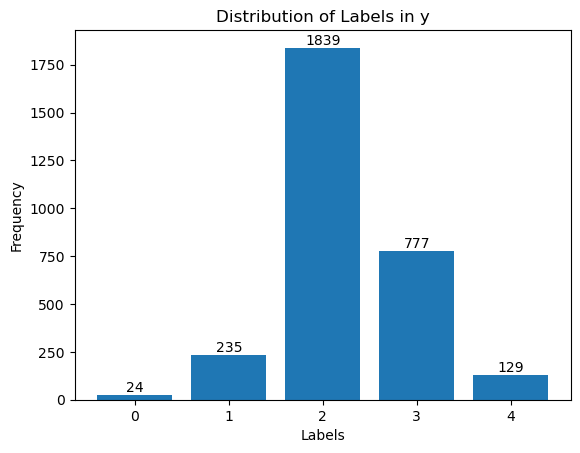

In [56]:
# Plot bar plot of y
counts = np.bincount(y)
plt.bar(range(len(counts)), counts)
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.title('Distribution of Labels in y')

# Annotate each bar with its count
for i, count in enumerate(counts):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.show()


## K-NN 

In [50]:
# Feature selection 
feature_selection = SelectKBest(score_func=f_classif)

# Define the pipeline with preprocessing, feature selection, and KNN classifier
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selection', feature_selection),
    ('knn', KNeighborsClassifier())
])

# Define parameter grid
param_grid = {
    'feature_selection__k': [10, 15, 20],  
    'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler()],  
    'knn__n_neighbors': [5, 7, 9, 11],  
    'knn__metric': ['euclidean', 'manhattan'],
    'knn__weights': ['uniform', 'distance'],
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Accuracy:", best_score)

# Evaluate on the validation set using the best model
knn_best_model = grid_search.best_estimator_
val_accuracy = accuracy_score(y_val, knn_best_model.predict(X_val))
print("Validation Accuracy with Best Model:", val_accuracy)


Best Parameters: {'feature_selection__k': 15, 'knn__metric': 'euclidean', 'knn__n_neighbors': 11, 'knn__weights': 'distance', 'preprocessor__num__scaler': MinMaxScaler()}
Best Accuracy: 0.6626014924351338
Validation Accuracy with Best Model: 0.6943521594684385


### Predict with KNN

In [51]:
# Make predictions on X_test with KNN
predictions = knn_best_model.predict(X_test)

# Create a DataFrame to store the predictions
prediction_df = pd.DataFrame({'id': range(1, len(predictions) + 1), 'imdb_score_binned': predictions})

# Write the predictions to a CSV file
prediction_df.to_csv('knn_predictions.csv', index=False)

## Decision Tree / Random Forest


In [73]:
# Define preprocessing steps
imputer = SimpleImputer(strategy='mean') 
feature_selector = SelectKBest(score_func=f_classif)  
classifier = RandomForestClassifier(random_state=42)

# Define the pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('imputer', imputer),
    ('feature_selector', feature_selector),
    ('classifier', classifier)
])

# Define parameter grid
param_grid = {
    'feature_selector__k': [10, 15],
    'classifier__n_estimators': [50, 100, 150], 
    # 'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5, 10],
    # 'classifier__min_samples_leaf': [1, 2, 4],
    # 'classifier__max_features': ['auto', 'sqrt']
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', verbose=0)
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Accuracy:", best_score)

# Evaluate on the validation set using the best model
rf_best_model = grid_search.best_estimator_
val_accuracy = rf_best_model.score(X_val, y_val)
print("Validation Accuracy with Best Model:", val_accuracy)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END classifier__min_samples_split=2, classifier__n_estimators=50, feature_selector__k=10; total time=   0.9s
[CV] END classifier__min_samples_split=2, classifier__n_estimators=50, feature_selector__k=10; total time=   0.8s
[CV] END classifier__min_samples_split=2, classifier__n_estimators=50, feature_selector__k=10; total time=   0.8s
[CV] END classifier__min_samples_split=2, classifier__n_estimators=50, feature_selector__k=10; total time=   0.8s
[CV] END classifier__min_samples_split=2, classifier__n_estimators=50, feature_selector__k=10; total time=   0.8s
[CV] END classifier__min_samples_split=2, classifier__n_estimators=50, feature_selector__k=15; total time=   0.8s
[CV] END classifier__min_samples_split=2, classifier__n_estimators=50, feature_selector__k=15; total time=   0.8s
[CV] END classifier__min_samples_split=2, classifier__n_estimators=50, feature_selector__k=15; total time=   1.1s
[CV] END classifier__min_sa

## Predict with Random Forest

In [ ]:
# Make predictions on X_test with Random Forest
predictions = rf_best_model.predict(X_test)

# Create a DataFrame to store the predictions
prediction_df = pd.DataFrame({'id': range(1, len(predictions) + 1), 'imdb_score_binned': predictions})

# Write the predictions to a CSV file
prediction_df.to_csv('rf_predictions.csv', index=False)

## SVM


In [49]:
# Define feature selection, imputation, and SVM classifier
imputer = SimpleImputer()
feature_selector = SelectKBest(score_func=f_classif)
classifier = SVC()

# Define the pipeline including feature engineering
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('imputer', imputer),
    ('feature_selector', feature_selector),
    ('classifier', classifier)
])

# Define parameter grid
param_grid = {
    'imputer__strategy': ['mean', 'median'],
    'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler()],  
    'feature_selector__k': [10, 15, 20],
    'classifier__C': [0.2, 1, 5],
    'classifier__gamma': ['scale', 'auto']
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', verbose=0)   # Verbose shows comments during search
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Accuracy:", best_score)

# Evaluate on the validation set using the best model
svm_best_model = grid_search.best_estimator_
val_accuracy = svm_best_model.score(X_val, y_val)
print("Validation Accuracy with Best Model:", val_accuracy)


Best Parameters: {'classifier__C': 5, 'classifier__gamma': 'scale', 'feature_selector__k': 10, 'imputer__strategy': 'mean', 'preprocessor__num__scaler': StandardScaler()}
Best Accuracy: 0.6803573629081947
Validation Accuracy with Best Model: 0.7308970099667774


### Predict with SVM

In [ ]:
# Make predictions on X_test with SVM
predictions = svm_best_model.predict(X_test)

# Create a DataFrame to store the predictions
prediction_df = pd.DataFrame({'id': range(1, len(predictions) + 1), 'imdb_score_binned': predictions})

# Write the predictions to a CSV file
prediction_df.to_csv('svm_predictions.csv', index=False)

## Permutation Feature Importance

id: 0.0
director_name: 0.0
num_critic_for_reviews: 0.057475083056478346
duration: 0.009634551495016564
director_facebook_likes: 0.0
actor_3_facebook_likes: 0.0
actor_2_name: 0.0
actor_1_facebook_likes: 0.0
gross: 0.05614617940199329
genres: 0.0
actor_1_name: 0.0
movie_title: 0.0
num_voted_users: 0.08272425249169431
cast_total_facebook_likes: 0.0
actor_3_name: 0.0
facenumber_in_poster: 0.0
plot_keywords: 0.0
num_user_for_reviews: 0.01295681063122921
language: 0.0
country: 0.0
content_rating: 0.0
title_year: 0.0
actor_2_facebook_likes: 0.0
movie_facebook_likes: 0.032890365448504946
title_embedding: 0.0
average_degree_centrality: 0.0
interaction_feature: 0.0


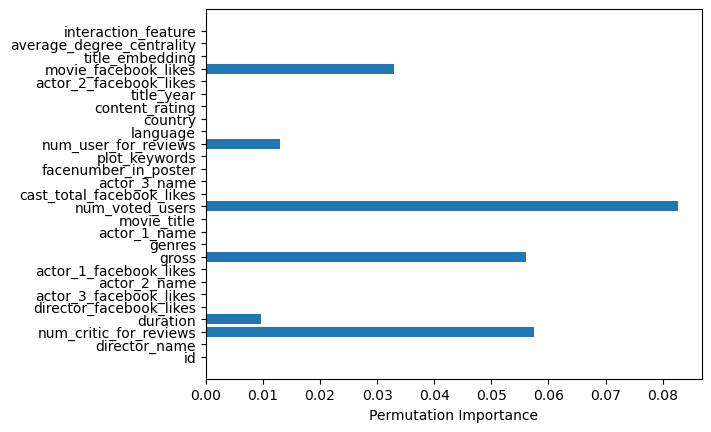

In [ ]:
from sklearn.inspection import permutation_importance

# Fit your SVM model (best_model) on the training data
svm_best_model.fit(X_train, y_train)

# Compute baseline performance on the validation set
baseline_score = svm_best_model.score(X_val, y_val)

# Compute permutation feature importance
perm_importance = permutation_importance(svm_best_model, X_val, y_val, n_repeats=10, random_state=42)

# Get feature importances and their names
feature_importances = perm_importance.importances_mean
feature_names = X_val.columns

# Print feature importance scores
for feature_name, importance in zip(feature_names, feature_importances):
    print(f"{feature_name}: {importance}")

# Plot feature importance
plt.barh(feature_names, feature_importances)
plt.xlabel('Permutation Importance')
plt.show()


### Compare csv's for different predictions


In [ ]:
# Read the first CSV file
df1 = pd.read_csv('knn_predictions.csv')

# Read the second CSV file
df2 = pd.read_csv('svm_predictions.csv')

# Compare the two DataFrames
differences = df1.compare(df2)

# Print the differences
print("Differences between csv1 with csv2")
print(differences)

Differences between csv1 with csv2
    imdb_score_binned      
                 self other
6                 4.0   3.0
7                 3.0   2.0
9                 2.0   3.0
18                3.0   2.0
30                2.0   4.0
..                ...   ...
722               3.0   2.0
735               3.0   4.0
740               1.0   2.0
747               2.0   3.0
748               3.0   2.0

[110 rows x 2 columns]


## View top models from grid search

In [72]:
def viewTopModels(results, num):
    # Sort the results by mean_test_score in descending order to find the top-performing models
    top_models = results.sort_values(by='mean_test_score', ascending=False).head(num)

    # Print the top models along with their parameters and scores
    print(f"Top {num} Models:")
    top_models[['params', 'mean_test_score']].to_csv("top_models.csv", index=False)
